In [10]:
setwd("~/Pruebas/master-cyb/data-sec")

In [11]:
pkg <- c("bitops","ggplot2", "maps", "maptools", "sp", "car" )
new.pkg <- pkg[!(pkg %in% installed.packages())]
if (length(new.pkg)) {
    install.packages(new.pkg)
}

In [3]:
library(bitops)

In [4]:
ip2long <- function(ip) {
    # convert string into vector of characters
    ips <- unlist(strsplit(ip, '.', fixed=TRUE))
    # set up a function to bit-shift, then "OR" the octets
    octet <- function(x,y) bitOr(bitShiftL(x, 8), y)
    # Reduce applys a function cumulatively left to right
    Reduce(octet, as.integer(ips))
}
# take an 32-bit integer IP address (e.g. 3232235521)
# and convert it to a (e.g. "192.168.0.1").
long2ip <- function(longip) {
    # set up reversing bit manipulation
    octet <- function(nbits) bitAnd(bitShiftR(longip, nbits), 0xFF)
    # Map applys a function to each element of the argument
    # paste converts arguments to character and concatenates them
    paste(Map(octet, c(24,16,8,0)), sep="", collapse=".")
}
long2ip(ip2long("192.168.0.0"))

[1] "192.168.0.0"

In [5]:
long2ip(ip2long("192.168.100.6"))

[1] "192.168.100.6"

In [6]:
ip.is.in.cidr <- function(ip, cidr) {
    long.ip <- ip2long(ip)
    cidr.parts <- unlist(strsplit(cidr, "/"))
    cidr.range <- ip2long(cidr.parts[1])
    cidr.mask <- bitShiftL(bitFlip(0),
                           (32-as.integer(cidr.parts[2])))
    return(bitAnd(long.ip, cidr.mask) == bitAnd(cidr.range,
                                                cidr.mask))
}
ip.is.in.cidr("10.0.1.15","10.0.1.3/24")

[1] TRUE

In [7]:
ip.is.in.cidr("10.0.1.15","10.0.2.255/24")

[1] FALSE

In [8]:
# Listing 4-3
# R code to extract longitude/latitude pairs from AlienVault data
# read in the AlienVault reputation data (see Chapter 3)
avRep <- "data/reputation.data"
av.df <- read.csv(avRep, sep="#", header=FALSE)
colnames(av.df) <- c("IP", "Reliability", "Risk", "Type",
"Country", "Locale", "Coords", "x")
# create a vector of lat/long data by splitting on ","
av.coords.vec <- unlist(strsplit(as.character(av.df$Coords), ","))
# convert the vector in a 2-column matrix
av.coords.mat <- matrix(av.coords.vec, ncol=2, byrow=TRUE)
# project into a data frame
av.coords.df <- as.data.frame(av.coords.mat)
# name the columns
colnames(av.coords.df) <- c("lat","long")
# convert the characters to numeric values
av.coords.df$long <- as.double(as.character(av.coords.df$long))
av.coords.df$lat <- as.double(as.character(av.coords.df$lat))

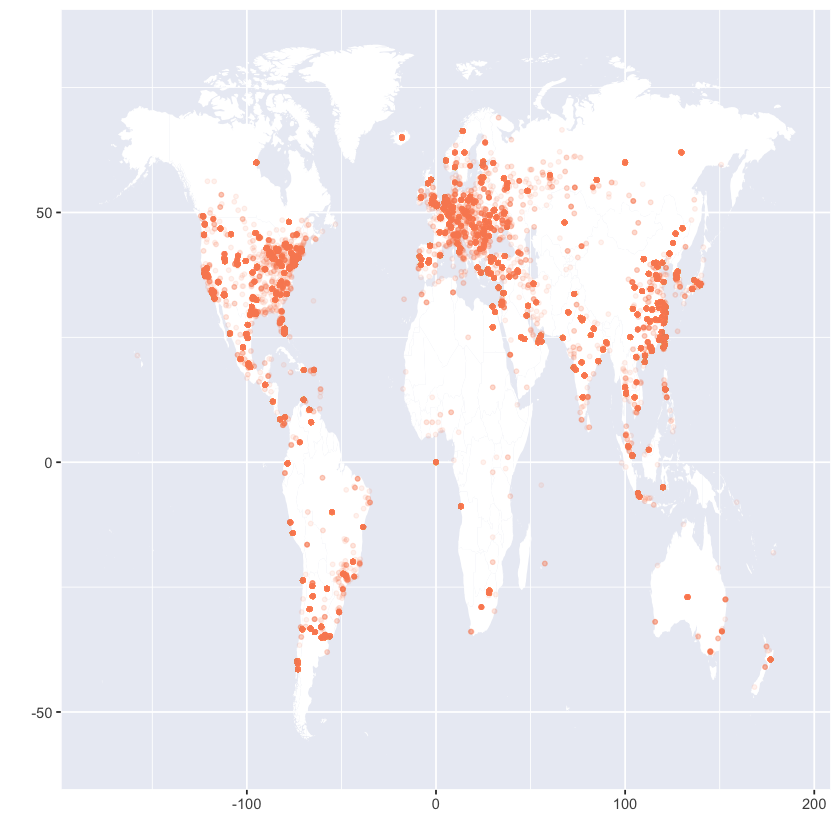

In [10]:
# Listing 4-4
# requires packages: ggplot2, maps, RColorBrewer
# requires object: av.coords.df (4-3)
# generates Figure 4-2
# R code to extract longitude/latitude pairs from AlienVault data
# need plotting and mapping functions
library(ggplot2)
library(maps)
library(RColorBrewer)
library(scales)
# extract a color pallete from the RColorBrewer package
set2 <- brewer.pal(8,"Set2")
# extract the polygon information for the world map, minus Antarctica
world <- map_data('world')
world <- subset(world, region != "Antarctica")
# plot the map with the points marking lat/lon of the geocoded entries
# Chapter 5 examples explain mapping in greater detail
gg <- ggplot()
gg <- gg + geom_polygon(data=world, aes(long, lat, group=group), fill="white")
gg <- gg + geom_point(data=av.coords.df, aes(x=long, y=lat), color=set2[2], size=1, alpha=0.1)
gg <- gg + labs(x="", y="")
gg <- gg + theme(panel.background=element_rect(fill=alpha(set2[3],0.2), colour='white'))
gg

In [16]:
# Listing 4-11
# Retrieve and read ZeuS blocklist data into R
zeusURL <- "https://zeustracker.abuse.ch/blocklist.php?\
download=ipblocklist"
zeusData <- "data/zeus-book.csv"
if (file.access(zeusData)) {
    # need to change download method for universal "https" compatibility
    download.file(zeusURL, zeusData, method="curl")
}
# read in the ZeuS table; skip junk; no header; assign colnames
zeus <- read.table(zeusData, skip=5, header=FALSE, col.names=c("IP"))

In [20]:
# HELPER FUNCTION MENTIONED IN THE BOOK
# BUT NOT IN THE PRINTED LISTINGS

BulkOrigin <- function(ip.list,host="v4.whois.cymru.com",port=43) {
 
  # setup query
  cmd <- "begin\nverbose\n" 
  ips <- paste(unlist(ip.list), collapse="\n")
  cmd <- sprintf("%s%s\nend\n",cmd,ips)
  
  # setup connection and post query 
  con <- socketConnection(host=host,port=port,blocking=TRUE,open="r+")  
  cat(cmd,file=con)
  response <- readLines(con)
  close(con)
  
  # trim header, split fields and convert results
  response <- response[2:length(response)]
  response <- laply(response,.fun=function(n) {
    sapply(strsplit(n,"|",fixed=TRUE),trim)
  })
  response <- adply(response,c(1))
  response <- subset(response, select = -c(X1) )
  names(response) = c("AS","IP","BGP.Prefix","CC",
                      "Registry","Allocated","AS.Name")
  
  return(response)
  
}

# HELPER FUNCTION MENTIONED IN THE BOOK
# BUT NOT IN THE PRINTED LISTINGS

BulkPeer <- function(ip.list,host="v4-peer.whois.cymru.com",port=43) {
   
  # setup query
  cmd <- "begin\nverbose\n" 
  ips <- paste(unlist(ip.list), collapse="\n")
  cmd <- sprintf("%s%s\nend\n",cmd,ips)
  
  # setup connection and post query
  con <- socketConnection(host=host,port=port,blocking=TRUE,open="r+")  
  cat(cmd,file=con)
  response <- readLines(con)
  close(con)
  
  # trim header, split fields and convert results
  response <- response[2:length(response)]
  response <- laply(response,function(n) {
    sapply(strsplit(n,"|",fixed=TRUE),trim)
  })  
  response <- adply(response,c(1))
  response <- subset(response, select = -c(X1) )
  names(response) <- c("Peer.AS","IP","BGP.Prefix","CC",
                       "Registry","Allocated","Peer.AS.Name")
  return(response)
  
}

In [21]:
library(igraph)
library(plyr)
library(colorspace)
# load the zeus botnet data used to perform the
# remainder of the analyses in the chapter
zeus <- read.table("data/zeus-book.csv", skip=5, header=FALSE,
col.names=c("IP"))
ips <- as.character(zeus$IP)
# get BGP origin data & peer data;
origin <- BulkOrigin(ips)
g <- graph.empty() # start graphing
# Make IP vertices; IP endpoints are red
g <- g + vertices(ips, size=4, color=set2[4], group=1)
# Make BGP vertices
g <- g + vertices(origin$CC, size=4, color=set2[2], group=2)
# for each IP address, get the origin AS CC and return
# them as a pair to create the IP->CC edge list
ip.cc.edges <- lapply(ips, function(x) {
    iCC <- origin[origin$IP==x, ]$CC
    lapply(iCC, function(y){
        c(x, y)
    })
})
g <- g + edges(unlist(ip.cc.edges)) # build CC->IP edges
# simplify the graph by combining commmon edges
g <- simplify(g, edge.attr.comb=list(weight="sum"))
# delete any standalone vertices (lone wolf ASNs). In "graph" terms
# delete any vertex with a degree of 0
g <- delete.vertices(g, which(degree(g) < 1))
E(g)$arrow.size <- 0 # we hate arrows
# blank out all the IP addresses to focus on ASNs
V(g)[grep("\\.", V(g)$name)]$name <- ""

ERROR: Error in sapply(strsplit(n, "|", fixed = TRUE), trim): object 'trim' not found


In [ ]:
# Listing 4-14
# require package: igraph (4-11)
# requires object: V() (4-11), g (4-11)
# read in country code to name translation table
zeus.cc <- grep("[A-Z]", V(g)$name, value=TRUE)
zeus.cc <- zeus.cc[order(zeus.cc)]
# read in the country codes data frame
cc.df <- read.csv("data/countrycode_data.csv")
# display cc & name for just the ones from our data set
print(head(cc.df[cc.df$iso2c %in% zeus.cc, c(7,1)], n=10), row.names=FALSE)

In [8]:
library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [12]:
# Listing 4-15
# requires objects: BulkOrigin() & BulkPeer() from book's web site
# require package: igraph (4-11)
# create connected network of ZeuS IPs, ASNs, and ASN peers
# generates Figure 4-9
g <- graph.empty()
g <- g + vertices(ips, size=3, color=set2[4], group=1)
origin <- BulkOrigin(ips)
peers <- BulkPeer(ips)
# add ASN origin & peer vertices
g <- g + vertices(unique(c(peers$Peer.AS, origin$AS)), size=3, color=set2[2], group=2)
# build IP->BGP edge list
ip.edges <- lapply(ips, function(x) {
    iAS <- origin[origin$IP==x, ]$AS
    lapply(iAS,function(y){
        c(x, y)
    })
})
bgp.edges <- lapply(
    grep("NA",unique(origin$BGP.Prefix),value=TRUE,invert=TRUE),
    function(x) {
        startAS <- unique(origin[origin$BGP.Prefix==x,]$AS)
        lapply(startAS,function(z) {
            pAS <- peers[peers$BGP.Prefix==x,]$Peer.AS
            lapply(pAS,function(y) {
                c(z,y)
            })
        })
    })
g <- g + edges(unlist(ip.edges))
g <- g + edges(unlist(bgp.edges))
g <- delete.vertices(g, which(degree(g) < 1))
g <- simplify(g, edge.attr.comb=list(weight="sum"))
E(g)$arrow.size <- 0
V(g)[grep("\\.", V(g)$name)]$name = ""
L <- layout.fruchterman.reingold(g, niter=10000, area=30*vcount(g)^2)
par(bg = 'white')
plot(g, margin=0, layout=L, vertex.label.dist=0.5, vertex.label=NA,
     main="ZeuS botnet ASN+Peer Network")

ERROR: Error in structure(list(...), class = "igraph.vertex"): object 'ips' not found
